In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

# Question 1.1

In [2]:
#Blocks the 'notification' popup on Chrome
options = Options()

options.add_argument('--disable-infobars')

options.add_experimental_option('prefs', {'profile.default_content_setting_values.notifications':1})

In [3]:
driver = webdriver.Chrome('/Users/shivamtandon/Desktop/ECO421/chromedriver', options = options)

website = 'https://www.reddit.com/'

driver.get(website)

post = driver.find_element_by_class_name('SQnoC3ObvgnGjWt90zD9Z')

post.click()

#### Post Title

In [4]:
post.text

'2021 Bahrain Grand Prix - Post Race Discussion'

In [6]:
#For the following code if an error pops up, copy and paste the same class id as below into the function

comment = driver.find_element_by_class_name('_3cjCphgls6DH-irkVaA0GM')

#### Post First Comment

In [7]:
comment.text

'That SAINZ - VET - ALO battle in the first half was soooo good...\nAnd a proper fight for the lead !!!\nAlso great hard racing in the midfield !!!\nIf this continues, we have got a great season on our hands !!'

In [8]:
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary

from gensim.models import LdaModel

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models import CoherenceModel

import seaborn as sns

from nltk.sentiment.vader import SentimentIntensityAnalyzer

pd.options.display.float_format = '{0:.4f}'.format

In [9]:
headlines = pd.read_csv('NYT_headlines.csv', parse_dates = True, usecols = [0,1,2])

headlines.sort_values('Unnamed: 0', inplace = True)

headlines.reset_index(inplace = True, drop = True)

In [10]:
headlines.set_index('date', inplace = True)

In [11]:
days = headlines.groupby('date').groups

date_headline = []

for key in list(days.keys()):
    
    date_headline.append(headlines.loc[str(key), 'Headlines'])

In [12]:
headlines_no_duplicate = []

for i in range(len(date_headline)):
    
    headlines_no_duplicate.append(date_headline[i].drop_duplicates())

In [13]:
headlines = pd.DataFrame(pd.concat(headlines_no_duplicate))

In [14]:
covid_dic = ['covid-19', 'covid', 'corona', 'coronavirus', 'pandemic', 
             'virus', 'quarantine', 'isolate', 'cases', 'cluster']

In [15]:
headlines_no_duplicate

[date
 2021-02-01    Inquiry Has Not Found Evidence to Charge Offic...
 2021-02-01    North Carolina Discontinues License Plates Wit...
 2021-02-01    McConnell says ‘loony lies’ spread by Marjorie...
 2021-02-01    Trump’s New Lawyers Not Expected to Focus on F...
 2021-02-01    Republicans Pitch Biden on Smaller Aid Plan as...
 2021-02-01    Tim Ryan, a Top Democrat in Ohio, Is Said to P...
 2021-02-01            Coronavirus Briefing: What Happened Today
 2021-02-01    Trump’s Sleight of Hand: Shouting Fraud, Pocke...
 2021-02-01    Watchdogs Appointed by Trump Pose Dilemma for ...
 2021-02-01    Jack Palladino, 76, Hard-Charging Private Inve...
 2021-02-01    Separated Families: A Legacy Biden Has Inherit...
 2021-02-01    Trump Official’s Last-Day Deal With ICE Union ...
 Name: Headlines, dtype: object,
 date
 2021-02-02      Explosion Critically Injures 3 Near Los Angeles
 2021-02-02    Three Skiers Found Dead After Avalanche in Col...
 2021-02-02    President Biden pays his respe

In [16]:
stop = set(stopwords.words('english'))

exclude = set(string.punctuation)
exclude.update(['’','“','”'])

lemma = WordNetLemmatizer()

def clean(doc):
    
    numb_free = ''.join([word for word in doc if not word.isdigit()]) # exclude digits
    punc_free = ''.join(word for word in numb_free if word not in exclude) # exclude puntuations
    stop_free = ' '.join([word for word in punc_free.lower().split() if word not in stop]) # exclude stopwords
    normalized = [lemma.lemmatize(word) for word in stop_free.split()] # bring word to its root
    normalized2 = ' '.join([word for word in normalized if len(word) != 1])

    return normalized2

In [17]:
clean_headlines = [clean(headline).split() for headline in headlines['Headlines']]

In [18]:
bigram = Phrases(clean_headlines, min_count = 5, threshold = 20)
trigram = Phrases(bigram[clean_headlines], min_count = 5, threshold = 20)

bigram_model = Phraser(bigram)
trigram_model = Phraser(trigram)

In [19]:
corpus = [trigram_model[bigram_model[headline]] for headline in clean_headlines]

dictionary = Dictionary(corpus)

In [20]:
bow_corpus = [dictionary.doc2bow(trigram_model[bigram_model[headline]]) for headline in clean_headlines]

In [21]:
K = np.arange(2, 21, 1)

lda_model = []

for num in K:

    lda_model.append(LdaModel(corpus = bow_corpus, id2word = dictionary, chunksize = 1700,
                        random_state = 42, iterations = 50, num_topics = num, passes = 20))

In [22]:
cv_coherence_model_lda = []


for model in lda_model:

    cv_coherence_model_lda_ = CoherenceModel(model = model, corpus = bow_corpus,
                   texts = corpus, dictionary = dictionary, coherence = 'c_v')

    cv_coherence_model_lda.append(cv_coherence_model_lda_.get_coherence())

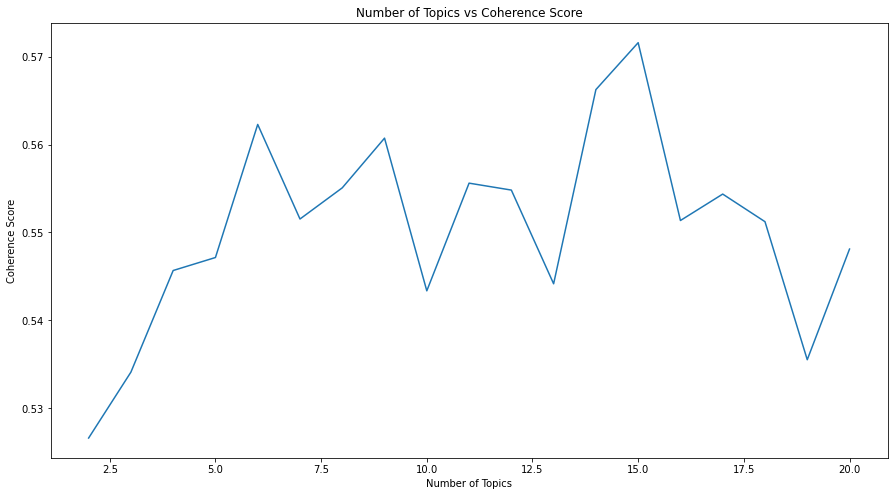

In [23]:
fig = plt.figure(figsize = (15,8))

plt.plot(K, cv_coherence_model_lda)

plt.title('Number of Topics vs Coherence Score')

plt.xlabel('Number of Topics')

plt.ylabel('Coherence Score')

plt.show()

In [24]:
K = K[cv_coherence_model_lda.index(max(cv_coherence_model_lda))]

In [25]:
lda_model = LdaModel(corpus = bow_corpus, id2word = dictionary, chunksize = 1700,
                        random_state = 42, iterations = 50, num_topics = K, passes = 40)

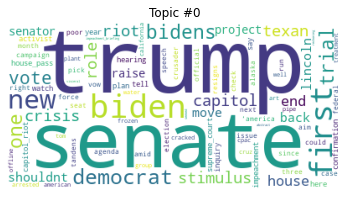

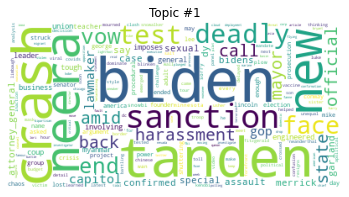

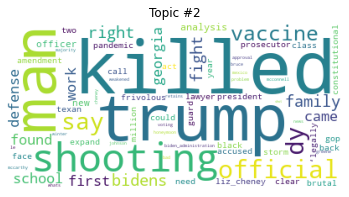

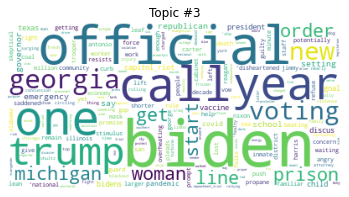

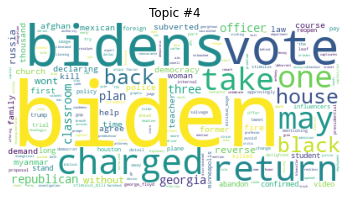

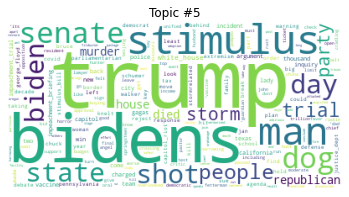

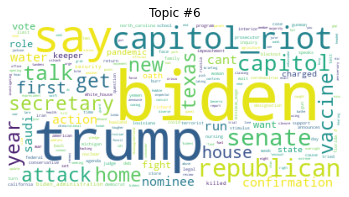

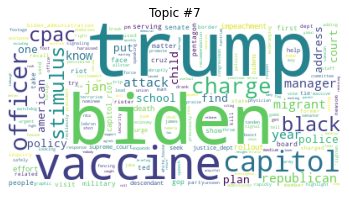

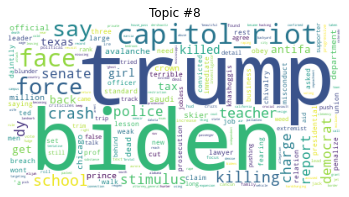

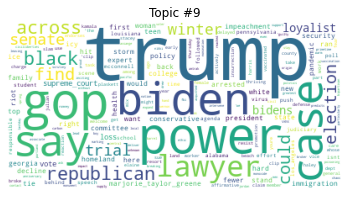

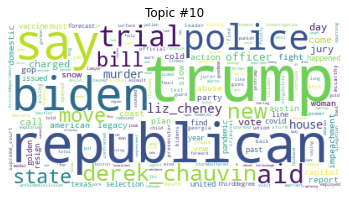

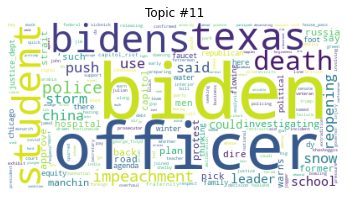

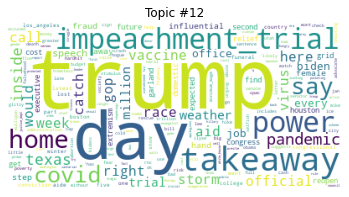

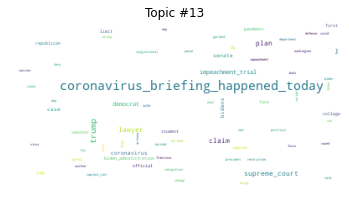

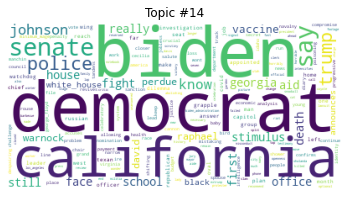

In [26]:
for i in range(lda_model.num_topics):
    
    plt.figure()
    plt.imshow(WordCloud(background_color = 'white').fit_words(dict(lda_model.show_topic(i, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(i))
    plt.show()

In [27]:
headlines_no_duplicate_lower = []

for i in range(len(headlines_no_duplicate)):
    
    for headline in headlines_no_duplicate[i]:
        
        headlines_no_duplicate_lower.append(headline.lower())

In [28]:
headlines_no_duplicate_lower = pd.DataFrame({'Headlines':headlines_no_duplicate_lower}, index = headlines.index)

In [29]:
days = headlines_no_duplicate_lower.groupby('date').groups

date_headline_lower = []

for key in list(days.keys()):
    
    date_headline_lower.append(headlines_no_duplicate_lower.loc[str(key), 'Headlines'])

In [30]:
def covid_uncertainty(daily_headlines):
    
    covid = []
    
    daily_headlines_ = list(daily_headlines)

    for headline in daily_headlines_:
        
        words = headline.split()
    
        for word in words:
        
            if word in covid_dic:
            
                covid.append(headline)
            
    return len(covid)/len(daily_headlines_)

In [31]:
covid_uncertain_index = []

for i in range(len(date_headline_lower)):
    
    index = covid_uncertainty(date_headline_lower[i])
    
    covid_uncertain_index.append(index)

In [32]:
date = pd.to_datetime(list(days.keys()))

In [33]:
covid_uncertain = pd.DataFrame({'COVID-19 Uncertainty Index': 
                                covid_uncertain_index}, index = date)

In [34]:
covid_uncertain

,COVID-19 Uncertainty Index
2021-02-01,0.0833
2021-02-02,0.0938
2021-02-03,0.1111
2021-02-04,0.0323
2021-02-05,0.0400
2021-02-06,0.0714
2021-02-07,0.0588
2021-02-08,0.1429
2021-02-09,0.0256
2021-02-10,0.0465


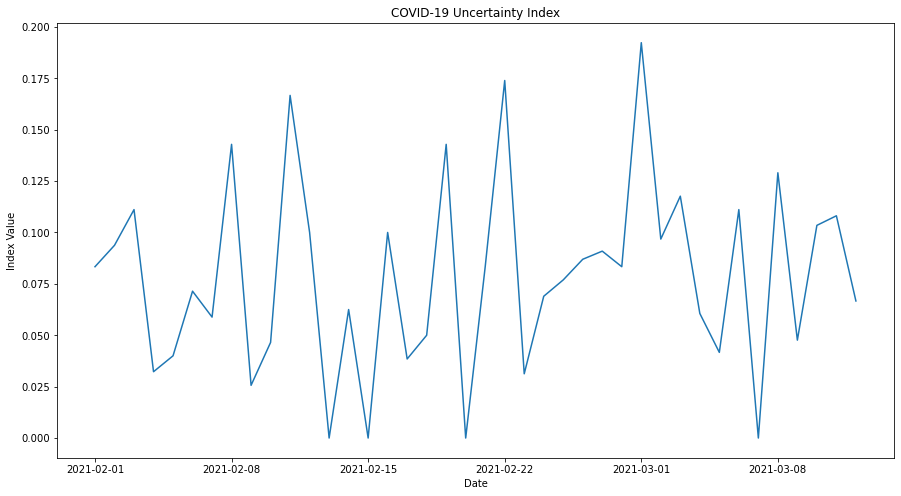

In [35]:
fig = plt.figure(figsize = (15,8))

plt.plot(covid_uncertain)

plt.title('COVID-19 Uncertainty Index')

plt.xlabel('Date')

plt.ylabel('Index Value')

plt.show()

In [36]:
econ_pol_words = ['uncertainty', 'uncertain', 'economic', 'economy', 
         'Congress', 'deficit', 'federal reserve', 'legislation', 
         'regulation', 'white house', 'uncertainties', 
         'regulatory', 'the fed']

In [37]:
def economy_policy_uncertainty(daily_headlines):
    
    econ_policy = []
    
    daily_headlines_ = list(daily_headlines)

    for headline in daily_headlines_:
        
        words = headline.split()
    
        for word in words:
        
            if word in econ_pol_words:
            
                econ_policy.append(headline)
            
    return len(econ_policy)/len(daily_headlines_)

In [38]:
econ_policy_uncertain_index = []

for i in range(len(date_headline_lower)):
    
    index = economy_policy_uncertainty(date_headline_lower[i])
    
    econ_policy_uncertain_index.append(index)

In [39]:
coarse_econ_policy_uncertain = pd.DataFrame({'Economic Policy Uncertainty Index': 
                                             econ_policy_uncertain_index}, index = date)

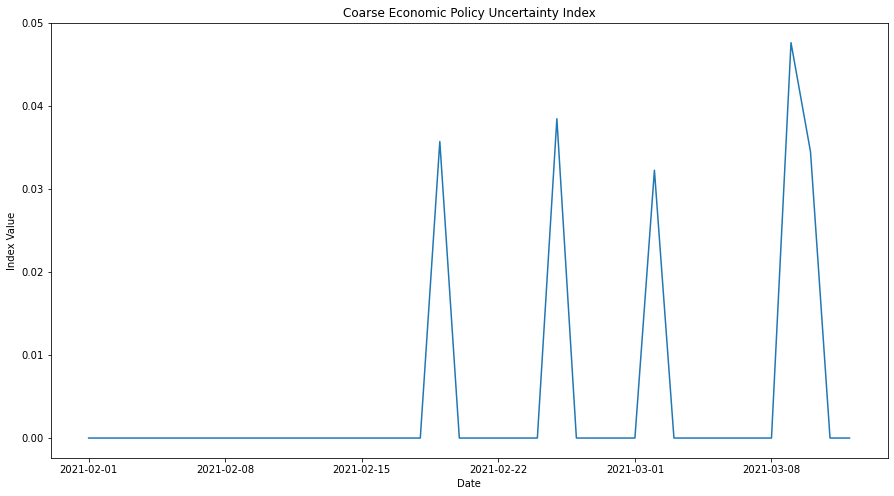

In [40]:
fig = plt.figure(figsize = (15,8))

plt.plot(coarse_econ_policy_uncertain)

plt.title('Coarse Economic Policy Uncertainty Index')

plt.xlabel('Date')

plt.ylabel('Index Value')

plt.show()

This is a poor method to indicate economic policy uncertainty since it relies on an ad-hoc list of words. A different list of words, still related to economic policy, could yield different daily measures of the index. Moreover, articles related to economic policy uncertainty do not necessarily have to refer to the given words in the headline. The headline alone can sometimes be unrelated to the article's content. As such, this method might underestimate the true index measure. For these reasons, the economic policy uncertainty index, calculated in this manner, is a poor indicator of true uncertainty. 

In [41]:
sp500 = pd.read_csv('SP500.csv', parse_dates = True, index_col = 'Date')

sp500.sort_index(inplace = True)

In [42]:
ret = pd.to_numeric(sp500['Adj Close**']).pct_change()

In [43]:
ret.dropna(inplace = True)

In [44]:
ret = ret.reindex(coarse_econ_policy_uncertain.index)

In [45]:
ret_covid_econ_pol_index = pd.DataFrame({'Return':ret, 
                                   'COVID-19 Uncertainty':covid_uncertain['COVID-19 Uncertainty Index'], 
                                   'Economic Policy Uncertainty':
                                         coarse_econ_policy_uncertain['Economic Policy Uncertainty Index']},
                                 index = ret.index)

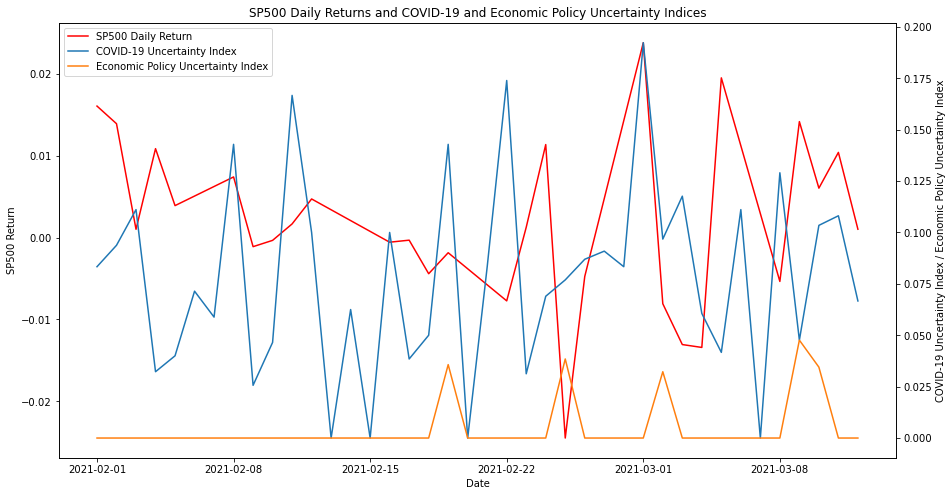

In [46]:
fig, ax = plt.subplots(figsize = (15,8))

l1 = ax.plot(ret_covid_econ_pol_index['Return'].dropna(), color = 'red', label = 'SP500 Daily Return')

ax_ = ax.twinx()

l2 = ax_.plot(ret_covid_econ_pol_index['COVID-19 Uncertainty'], label = 'COVID-19 Uncertainty Index')

l3 = ax_.plot(ret_covid_econ_pol_index['Economic Policy Uncertainty'], label = 'Economic Policy Uncertainty Index')

ax.set_xlabel('Date')

ax.set_ylabel('SP500 Return')
ax_.set_ylabel('COVID-19 Uncertainty Index / Economic Policy Uncertainty Index')

ax.set_title('SP500 Daily Returns and COVID-19 and Economic Policy Uncertainty Indices')

lns = l1 + l2 + l3

labels = [l.get_label() for l in lns]

ax.legend(lns, labels, loc = 'upper left')

plt.show()

In [47]:
ret_covid_econ_pol_index.corr()

,Return,COVID-19 Uncertainty,Economic Policy Uncertainty
Return,1.0000,0.0178,-0.1816
COVID-19 Uncertainty,0.0178,1.0000,0.0944
Economic Policy Uncertainty,-0.1816,0.0944,1.0000


The above graph plots the SP500 returns on the left y-axis and the COVID-19 uncertainty index and the coarse economic policy uncertainty index on the right y-axis. The dates are plotted on the x-axis. As seen from the graph, large spikes in the economic policy uncertainty index are followed by substantial drops in the SP500 returns. However, large spikes in the COVID-19 uncertainty index are followed by substanital increases in the SP500 returns. This is evident by the above correlation matrix which shows positive correlation between the SP500 returns and the COVID-19 uncertainty index and a negative correlation between the SP500 returns and the coarse economic policy index. While a negative correlation coefficient is expected between SP500 returns and the coarse economic policy index, a positive correlation coefficient between SP500 returns and the COVID-19 uncertainty index is surprising. However, note with recent vaccine developments, COVID-19 news is likely to be positive. This uncertainty is beneficial for equity markets and is represented by the positive correlation coefficient. 

In [48]:
#Define a function that calculates sentiment scores for a document

def sentiment_vader(doc):
    
    analyzer = SentimentIntensityAnalyzer()
    
    score = analyzer.polarity_scores(doc)
    
    return [score["compound"],score["pos"],score["neg"], score['neu']]

In [49]:
sentiment = [] 

index = []

for i in range(len(date_headline_lower)):

    for headline in date_headline_lower[i]:
        
        words = headline.split()
        
        for word in words:
            
            if word in covid_dic:
            
                sentiment.append(sentiment_vader(headline))
                
                pos = list(date_headline_lower[i]).index(headline)
                
                index.append(date_headline_lower[i].index[pos])

In [50]:
index = pd.to_datetime(index)

In [51]:
sentiment = pd.DataFrame(sentiment, columns = ['Final Score', 'Positive', 'Negative', 'Neutral'], index = index)

sentiment.reset_index(inplace = True)

In [52]:
sentiment = sentiment.groupby('index').mean()

In [53]:
sentiment

,Final Score,Positive,Negative,Neutral
index,,,,
2021-02-01,0.0000,0.0000,0.0000,1.0000
2021-02-02,-0.0911,0.0000,0.0863,0.9137
2021-02-03,-0.0263,0.0940,0.1185,0.7875
2021-02-04,0.0000,0.0000,0.0000,1.0000
2021-02-05,0.0000,0.0000,0.0000,1.0000
2021-02-06,0.5760,0.4500,0.0000,0.5500
2021-02-07,0.2732,0.2850,0.2040,0.5110
2021-02-08,0.0000,0.0000,0.0000,1.0000
2021-02-09,0.0000,0.0000,0.0000,1.0000


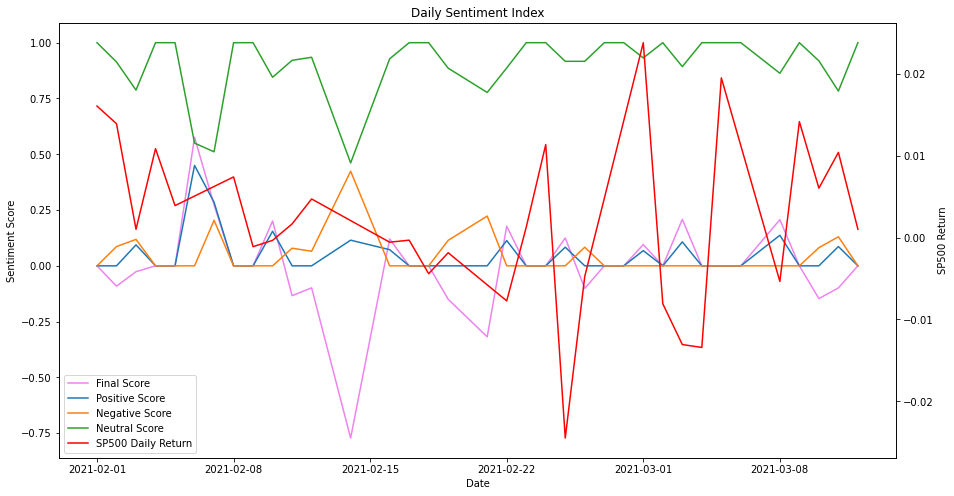

In [54]:
fig, ax = plt.subplots(figsize = (15,8))

l1 = ax.plot(sentiment.iloc[:,0], color = 'violet', label = 'Final Score')

l2 = ax.plot(sentiment.iloc[:,1], label = 'Positive Score')

l3 = ax.plot(sentiment.iloc[:,2], label = 'Negative Score')

l4 = ax.plot(sentiment.iloc[:,3], label = 'Neutral Score')

ax_ = ax.twinx()

l5 = ax_.plot(ret.dropna(), color = 'red', label = 'SP500 Daily Return')

ax.set_title('Daily Sentiment Index')

ax.set_xlabel('Date')

ax.set_ylabel('Sentiment Score')

ax_.set_ylabel('SP500 Return')

lns = l1 + l2 + l3 + l4 + l5

labels = [l.get_label() for l in lns]

plt.legend(lns, labels, loc = 'lower left')

plt.show()

In [55]:
agg_headline_sentiment = str(headlines_no_duplicate_lower.values)

In [56]:
sentiment_vader(agg_headline_sentiment)

[-0.7783, 0.0, 0.095, 0.905]

Since this is a small dataset, with mostly neutral data as inferred from the graph above, it is difficult to formulate concrete data insights. However some findings can be observed. For instance, COVID-19 related news seems to be positive due to the positive correlation coefficient between COVID-19 uncertainity index and the SP500 returns. Perhaps, the spikes in the positive score line, in the graph above, due to their seemingly regular frequency could be referring to COVID-19 related news. Moreover, notice positive values of the final score line tend to give rise to upward trajectory to SP500 returns whereas negative values tend to give rise to downward trajectory to SP500 returns. 